# Example of PELSA differential expression with `alphatools`

## An example dataset: The original PELSA publication

PELSA [1] is a novel method to investigate protein-ligand interactions through limited proteolysis. Cell lysate is treated with a short pulse of trypsin at extremely high (1:2) enzyme - substrate ratio, which allows for the digestion of surface exposed peptides. If a ligand (such as a small molecule binder) is bound to the protein surface, it stablizes the surrounding protein region and digestion is momentarily slowed. When compared against a control without the ligand, the PELSA-stabilized peptides appear downregulated. We replicate the original publication's analysis of Staurosporine, a pan-kinase binder, and visualize the regulation of kinase targets.

[1]: Li, Kejia, et al. "A peptide-centric local stability assay enables proteome-scale identification of the protein targets and binding regions of diverse ligands." Nature Methods 22.2 (2025): 278-282.

In [ ]:
%load_ext autoreload
%autoreload 2

import tempfile
import pandas as pd
import logging
from alphatools import io, pp, pl, tl  # input/output, preprocessing, plotting and tools modules
from alphabase.tools.data_downloader import DataShareDownloader

logger = logging.getLogger(__name__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preparing the dataset using `alphatools` loaders and AnnData factory. 

After downloading the relevant files from the study's PRIDE-repository (https://www.ebi.ac.uk/pride/archive/projects/PXD034606):

- LKJ_20211007_480_Hela_stau_0uM_1.raw
- LKJ_20211007_480_Hela_stau_0uM_2.raw
- LKJ_20211007_480_Hela_stau_0uM_3.raw
- LKJ_20211007_480_Hela_stau_0uM_4.raw
- LKJ_20211007_480_Hela_stau_20uM_1.raw
- LKJ_20211007_480_Hela_stau_20uM_2.raw
- LKJ_20211007_480_Hela_stau_20uM_3.raw
- LKJ_20211007_480_Hela_stau_20uM_4.raw

And processing them with DIANN 2.1.0, the report.parquet file was saved in our datashare alongside sample metadata. We have to extract protein-level intensities and precursor-level intensities from this dataset using the `alphatools.io.AnnDataFactory` class. The resulting AnnData object contains protein-group or precursor quantities and any number of feature-metadata columns (for example, protein groups may have genes as secondary annotation, precursors may have protein groups and genes as secondary annotation).

In [ ]:
report_url = "https://datashare.biochem.mpg.de/s/6piDQGm2yAEdtKQ/download"
sample_metadata_url = "https://datashare.biochem.mpg.de/s/NGof744gWw66Mc8/download"

# Get the report by downloading it to a temporary directory and directly loading it from there
with tempfile.TemporaryDirectory() as temp_dir:
    file_path = DataShareDownloader(url=report_url, output_dir=temp_dir).download()

    # Get the full report
    full_report = pd.read_parquet(file_path)

    # AnnDataFactory instance containing protein level data
    adata_protein = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="PG.MaxLFQ",
        feature_id_column="Protein.Group",
        sample_id_column="Run",
        secondary_feature_columns=["genes"],
    )

    # AnnDataFactory instance containing gene level data
    adata_gene = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="Genes.MaxLFQ",
        feature_id_column="Genes",
        sample_id_column="Run",
        secondary_feature_columns=["proteins"],
    )

    # AnnDataFactory instance containing precursor level data
    adata_precursor = io.read_psm_table(
        file_paths=file_path,
        search_engine="diann",
        intensity_column="Precursor.Normalised",
        feature_id_column=["Precursor.Id", "Genes", "Protein.Group"],
        sample_id_column="Run",
        secondary_feature_columns=["genes", "sequence"],
    )

/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp8wkzetqx/report.parquet does not yet exist


100% |########################################################################|


/var/folders/2l/hhd_z4hx3070zw8rlj4c3l940000gn/T/tmp8wkzetqx/report.parquet successfully downloaded (70.8467435836792 MB)


### We focus on Protein Groups and Precursors, and use `pp.add_metadata()` to merge the metadata into our AnnData instances

In [ ]:
# Transfer the run names to the sample metadata to account for lack of rawfile names in the metadata
sample_metadata = pd.read_csv(sample_metadata_url)
sample_metadata["sample"] = sample_metadata["plate"] + "_" + sample_metadata["running_count"].astype(str)

run_name_map = {"_".join(k.split("_")[-2:]): k for k in adata_protein.obs_names}
sample_metadata.index = sample_metadata["sample"].map(run_name_map)

In [ ]:
# Add the metadata to all AnnData instances
adata_protein = pp.add_metadata(adata_protein, sample_metadata, axis=0)
adata_precursor = pp.add_metadata(adata_precursor, sample_metadata, axis=0)

### We log2-transform our data, but keep the untransformed values in a separate layer

In [ ]:
adata_protein.layers["raw"] = adata_protein.X.copy()
adata_precursor.layers["raw"] = adata_precursor.X.copy()

adata_protein = pp.nanlog(adata_protein)
adata_precursor = pp.nanlog(adata_precursor)

In [ ]:
# Inspect the log2-transformed values:
display(adata_protein.to_df().iloc[:5, :5])

# Raw values:
display(adata_protein.to_df(layer="raw").iloc[:5, :5])

proteins,A0A096LP55;P07919,A0A0B4J2F0,A0A1B0GUY1,A0A3B3IS91,A0A3B3IU46;Q9BTL3
raw_name,,,,,
LKJ_20211007_480_Hela_stau_0uM_1,21.790016,23.018673,24.692411,17.029541,23.745449
LKJ_20211007_480_Hela_stau_0uM_2,21.902254,23.051476,24.746101,17.110256,23.861660
LKJ_20211007_480_Hela_stau_0uM_3,21.277990,23.003662,24.555399,17.807335,23.645226
LKJ_20211007_480_Hela_stau_0uM_4,21.540596,23.048594,24.787121,16.149979,23.457727
LKJ_20211007_480_Hela_stau_20uM_1,21.918283,23.059902,24.633326,NaN,23.821888


proteins,A0A096LP55;P07919,A0A0B4J2F0,A0A1B0GUY1,A0A3B3IS91,A0A3B3IU46;Q9BTL3
raw_name,,,,,
LKJ_20211007_480_Hela_stau_0uM_1,3626171.50,8497893.0,27111686.0,133783.515625,14063468.0
LKJ_20211007_480_Hela_stau_0uM_2,3919543.50,8693320.0,28139656.0,141481.781250,15243168.0
LKJ_20211007_480_Hela_stau_0uM_3,2542808.25,8409926.0,24655366.0,229372.937500,13119653.0
LKJ_20211007_480_Hela_stau_0uM_4,3050461.00,8675965.0,28951204.0,72715.656250,11520718.0
LKJ_20211007_480_Hela_stau_20uM_1,3963336.50,8744247.0,26023742.0,NaN,14828694.0


### Perform basic EDA on protein and precursor data

Starting with a panel for feature counts and CVs in each sample

In [ ]:
# Small custom function to generate CVs
# In the future, this could become an alphatools core functionality
import anndata as ad


def make_group_cvs(
    adata: ad.AnnData,
    group_column: str,
) -> None:
    """Calculate CVs for each group in group_columns and store them in adata.var"""
    levels = adata.obs[group_column].unique()
    for level in levels:
        group_adata = pp.filter_by_metadata(adata, {group_column: level}, axis=0)
        stds = group_adata.to_df(layer="raw").std(axis=0)
        means = group_adata.to_df(layer="raw").mean(axis=0)
        adata.var[f"{level}_CV"] = stds / means


# Calculate CVs for the different groups in the condition column
make_group_cvs(adata_protein, "treatment")
make_group_cvs(adata_precursor, "treatment")

We use `alphatools`' plotting syntax to generate a stylized panel with violin plots for sample group feature CVs, and to assess the median intensity of all features across samples.

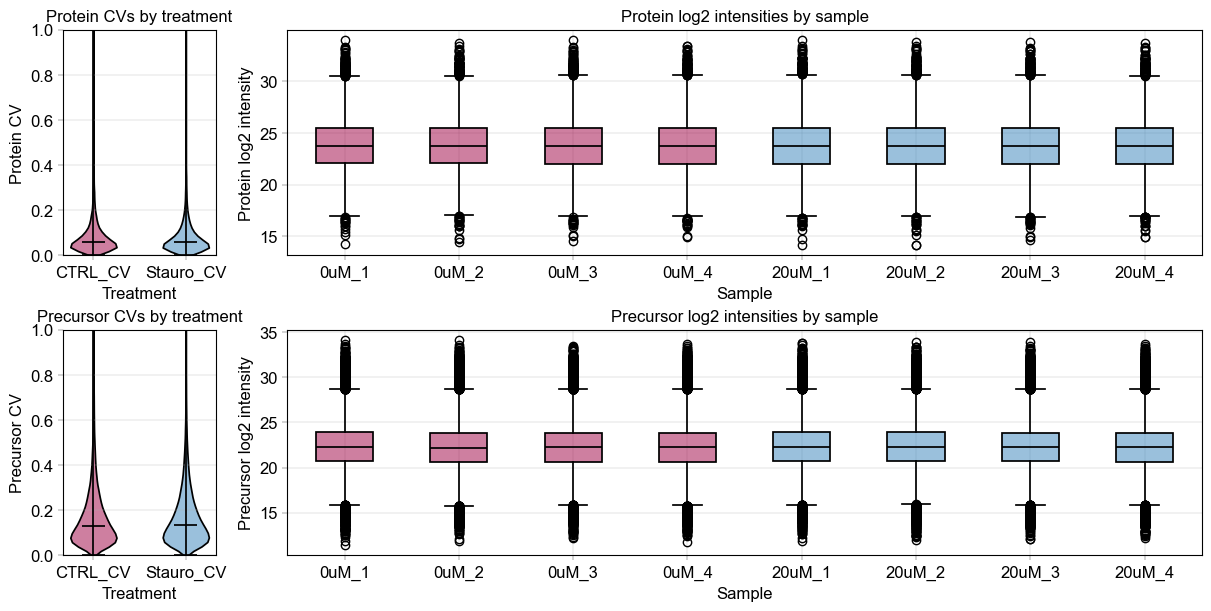

In [ ]:
fig, axm = pl.create_figure(2, 2, figsize=(12, 6), gridspec_kwargs={"width_ratios": [0.5, 3]})

# Define color dictionary for the different treatments
color_dict = {
    "CTRL": pl.BaseColors.get("red"),
    "Stauro": pl.BaseColors.get("blue"),
}

# Map the sample names to their respective colors based on treatment
sample_color_dict = {
    sample: color_dict[treatment]
    for sample, treatment in zip(adata_protein.obs_names, adata_protein.obs["treatment"], strict=False)
}

# Iterative plotting
plot_data = {
    "protein": adata_protein,
    "precursor": adata_precursor,
}
for readout, adata in plot_data.items():
    # start with the CV plots
    ax = axm.next()
    pl.Plots.violinplot(
        ax=ax,
        data=adata.T,
        direct_columns=["CTRL_CV", "Stauro_CV"],
        color_dict={f"{k}_CV": v for k, v in color_dict.items()},
    )
    ax.set_ylim(0, 1)

    pl.label_axes(
        ax=ax,
        xlabel="Treatment",
        ylabel=f"{readout.capitalize()} CV",
        title=f"{readout.capitalize()} CVs by treatment",
    )

    # Then do the log2 abundance plots
    ax = axm.next()
    pl.Plots.boxplot(
        ax=ax,
        data=adata.T,
        direct_columns=adata.obs_names.tolist(),
        color_dict=sample_color_dict,
    )

    # process x ticks to fit the plot better
    xtick_labels = [item.get_text() for item in ax.get_xticklabels()]  # Get xtick labels directly from axes
    xtick_labels = [
        "_".join(x.split("_")[-2:]) for x in xtick_labels
    ]  # Shorten the xtick labels to make them more readable
    _ = ax.set_xticklabels(xtick_labels)  # Set the new xtick labels

    pl.label_axes(
        ax=ax,
        xlabel="Sample",
        ylabel=f"{readout.capitalize()} log2 intensity",
        title=f"{readout.capitalize()} log2 intensities by sample",
    )

    # save figure
    pl.save_figure(
        fig=fig,  # Note that here we're using the whole figure to whose axes we added our plots
        filename="pelsa_quantities_overview.svg",
        output_dir="./example_outputs",
    )

### PELSA analysis depends on differential expression

Peptides from the stablized protein regions are expected to appear downregulated. We perform comparative differential expression analysis: On the one hand, we evaluate "vanilla" independent two-sample t-test. On the other, we employ `alphatools`' wrapper of `AlphaQuant` [1], a differential expression method specially adapted for mass-spectrometry proteomics data.

[1]: Ammar, Constantin, et al. "Tree-based quantification infers proteoform regulation in bottom-up proteomics data." bioRxiv (2025): 2025-03.

In [ ]:
comparison = ("Stauro", "CTRL")

In [ ]:
# Vanilla ttest on peptide data
ttest_results = tl.diff_exp_ttest(
    adata=adata_precursor,
    between_column="treatment",
    comparison=comparison,
    min_valid_values=2,
    equal_var=False,
)

/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **k

In [ ]:
# AlphaQuant ttest on full search engine output
tl.diff_exp_alphaquant(
    adata=adata_precursor,
    report=full_report,
    between_column="treatment",
    comparison=comparison,
    valid_values_filter_mode="either",
    min_valid_values=2,
    plots="hide",
)

TypeError: read_table() got an unexpected keyword argument 'sep'

In [ ]:
ttest_results

,condition_pair,protein,log2fc,p_value,-log10(p_value),fdr,-log10(fdr),method
(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVR3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVR3,-0.779221,0.035807,1.446031,0.944538,0.024780,ttest
(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVRK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAGDSDSWDADAFSVEDPVRK3,-0.163618,0.528045,0.277329,0.986822,0.005761,ttest
(UniMod:1)AAAAAAAPSGGGGGGEEERLEEK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAAPSGGGGGGEEERLEEK3,0.131008,0.220292,0.657002,0.986822,0.005761,ttest
(UniMod:1)AAAAAAGAASGLPGPVAQGLK3,Stauro_VS_CTRL,(UniMod:1)AAAAAAGAASGLPGPVAQGLK3,-0.001898,0.984930,0.006595,0.999645,0.000154,ttest
(UniMod:1)AAAAAAGEAR2,Stauro_VS_CTRL,(UniMod:1)AAAAAAGEAR2,0.120327,0.652235,0.185596,0.990291,0.004237,ttest
...,...,...,...,...,...,...,...,...
YYWDEYK2,Stauro_VS_CTRL,YYWDEYK2,NaN,NaN,NaN,NaN,NaN,ttest
YYYIPQYK2,Stauro_VS_CTRL,YYYIPQYK2,0.139555,0.687191,0.162923,0.990748,0.004037,ttest
YYYQLNSK2,Stauro_VS_CTRL,YYYQLNSK2,0.039896,0.713982,0.146313,0.990909,0.003966,ttest
YYYSDNFFDGQR2,Stauro_VS_CTRL,YYYSDNFFDGQR2,-0.014498,0.935844,0.028796,0.998053,0.000846,ttest
